# Partial differential equations

Partial differential equations occur when we are dealing with functions of more than one variable, for instance *fields*.

Examples:

- Electrostatic potential $\phi (x,y,z)$ (Poisson's equation)
$$
\Delta\phi(x,y,z) = -\frac{\rho(x,y,z)}{\epsilon_0}
$$

- Density or temperature profiles (diffusion/heat equation)
$$
\frac{\partial u(\mathbf{x},t)}{\partial t} = D \Delta u(\mathbf{x},t)
$$

- Displacement (amplitude) profile (wave equation)
$$
\frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} = c^2\Delta u(\mathbf{x},t)
$$

- Fluid dynamical fields (flow velocity) -- e.g. Navier-Stokes equations 

## General methods for solving PDE's

- **Finite difference method**
    - Approximate the derivatives by finite differences
    - Easier to implement than other methods
    - Works best for regular (rectangular) shapes
- Finite element method
    - Subdivide the system into smaller parts -- finite elements
    - Boundary value problems in 2/3 dimensions
    - Works well for irregular shapes
- Finite volume method
    - Convert surface integrals around each mesh point into volume integrals
    - Conserves mass by design, good for fluid dynamical equations

## Boundary value problems

<img src="http://www-personal.umich.edu/~mejn/cp/figures/fig9-2.png" alt="Electrostatics problem" style="width: 400px;"/> 
<center>
    Source: M. Newman, Computational Physics
</center>

Boundary value problems typically deal with static solutions (no time variable)

Consider Laplace's equation (no external charges) in two dimensions
$$
\frac{\partial^2 \phi(x,y)}{\partial x^2}
+
\frac{\partial^2 \phi(x,y)}{\partial y^2}
=
0.
$$



Boundary conditions: one of the walls has voltage $V$ applied to it, the rest are grounded:
\begin{align*}
\phi(x,L) & = V, \\
\phi(x,0) & = 0, \\
\phi(0,y) & = 0, \\
\phi(L,y) & = 0.
\end{align*}

Let us apply finite difference method. 
Discretize the box into a grid in steps $a = L / M$ in each direction.
Approximate the derivatives by central differences:
\begin{align*}
\frac{\partial^2 \phi(x,y)}{\partial x^2} & = \frac{\phi(x+a,y) - 2\phi(x,y) + \phi(x-a,y)}{a^2}, \\
\frac{\partial^2 \phi(x,y)}{\partial y^2} & = \frac{\phi(x,y+a) - 2\phi(x,y) + \phi(x,y-a)}{a^2}.
\end{align*}

The Laplace's equation becomes
$$
\phi(x+a,y) + \phi(x-a,y) + \phi(x,y+a) + \phi(x,y-a) - 4 \phi(x,y) = 0.
$$

In principle, this is a system of $N \sim M^2$ linear equations that can be solved exactly.
The general method will however require $O(N^3) = O(M^6)$ operations which becomes unfeasible already for $M \sim 100$ or so.

## Jacobi (relaxation) method

Start with some initial guess $\phi_0(x,y)$. The next iteration is given by
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$
for all points inside the box. Preserve the boundary conditions at each iteration:
\begin{align*}
\phi_{n+1}(x,L) & = V, \\
\phi_{n+1}(x,0) & = 0, \\
\phi_{n+1}(0,y) & = 0, \\
\phi_{n+1}(L,y) & = 0.
\end{align*}

This is the Jacobi (or relaxation) method, and for Laplace's equation it is always converges.

In [16]:
import numpy as np

# Single iteration of the Jacobi method
# The new field is written into phinew
def iteration_jacobi(phinew, phi):
    M = len(phi) - 1
    
    # Boundary conditions
    phinew[0,:] = phi[0,:]
    phinew[M,:] = phi[M,:]
    phinew[:,0] = phi[:,0]
    phinew[:,M] = phi[:,M]
    
    for i in range(1,M):
        for j in range(1,M):
            phinew[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4
                
    delta = np.max(abs(phi-phinew))
    
    return delta

def jacobi_solve(phi0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = iteration_jacobi(phi, phi0)
        phi0, phi = phi, phi0
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi0
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 1909 iterations


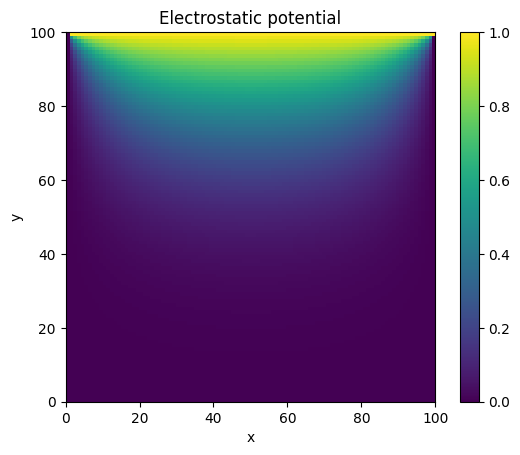

CPU times: user 7.29 s, sys: 78.4 ms, total: 7.37 s
Wall time: 7.37 s


In [18]:
%%time
# Measure execution time

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0

phi = jacobi_solve(phi, target, 10000)

# Plot
import matplotlib.pyplot as plt

plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

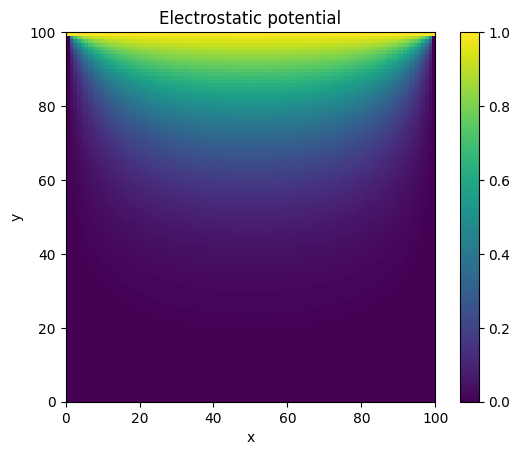

CPU times: user 9.71 s, sys: 125 ms, total: 9.83 s
Wall time: 10 s


In [3]:
%%time

## This is adapted Example 9.1 from M. Newman, "Computational Physics"
## Source: http://www-personal.umich.edu/~mejn/cp/programs/laplace.py

from numpy import empty,zeros,max
from pylab import imshow,gray,show

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Create arrays to hold potential values
phi = zeros([M+1,M+1],float)
phi[0,:] = V
phiprime = empty([M+1,M+1],float)

# Main loop
delta = 1.0
while delta>target:

    # Calculate new values of the potential
    for i in range(M+1):
        for j in range(M+1):
            if i==0 or i==M or j==0 or j==M:
                phiprime[i,j] = phi[i,j]
            else:
                phiprime[i,j] = (phi[i+1,j] + phi[i-1,j] \
                                 + phi[i,j+1] + phi[i,j-1])/4

    # Calculate maximum difference from old values
    delta = max(abs(phi-phiprime))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi

# Make a plot
# imshow(phi)
# gray()
# show()
plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

## Gauss-Seidel method with overrelaxation

The base Jacobi method corresponds to an iteration
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4}
$$

This requires to have two arrays independently.
In Gauss-Seidel method one uses the already computed values of $\phi_{n+1}$ where availabl instead.
The method thus corresponds to
$$
\phi_{n+1}(x,y) = \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4}
$$

Another modification is the use of overrelaxation.

The base Jacobi method is a type of relaxation method
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + \Delta_n \phi(x,y).
$$

A way to speed-up calculation is to overrelaxate the solution a bit
$$
\phi_{n+1}(x,y) = \phi_n(x,y) + (1+\omega) \Delta_n \phi(x,y),
$$
where $\omega > 0$.

This implies the following iterative procedure
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_n(x-a,y) + \phi_n(x,y+a) + \phi_n(x,y-a)}{4} - \omega \, \phi_n(x,y).
$$

This is unstable for $\omega > 0$. However, applied to Gauss-Seidel method, this corresponds to
$$
\phi_{n+1}(x,y) = (1+\omega) \frac{\phi_n(x+a,y) + \phi_{n+1}(x-a,y) + \phi_n(x,y+a) + \phi_{n+1}(x,y-a)}{4} - \omega \, \phi_n(x,y),
$$
and provides generally stable solution for $\omega < 1$. 

In [19]:
import numpy as np

# Single iteration of the Jacobi method
# The new field is written into phinew
# omega >= 0 is the overelaxation parameter
def gaussseidel_iteration(phi, omega = 0):
    M = len(phi) - 1
    
    delta = 0.
    
    # New iteration
    for i in range(1,M):
        for j in range(1,M):
            phiold = phi[i,j]
            phi[i,j] = (1. + omega) * (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 - omega * phi[i,j]
            delta = np.maximum(delta, abs(phiold - phi[i,j]))
    
    return delta

def gaussseidel_solve(phi0, omega = 0, target_accuracy = 1e-6, max_iterations = 100):
    delta = target_accuracy + 1.
    phi = phi0.copy()
    for i in range(max_iterations):
        delta = gaussseidel_iteration(phi, omega)
        
        if (delta <= target_accuracy):
            print("Jacobi method converged in " + str(i+1) + " iterations")
            return phi
        
    print("Jacobi method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    print("The error estimate is ", delta)
        
    return phi

Jacobi method converged in 137 iterations


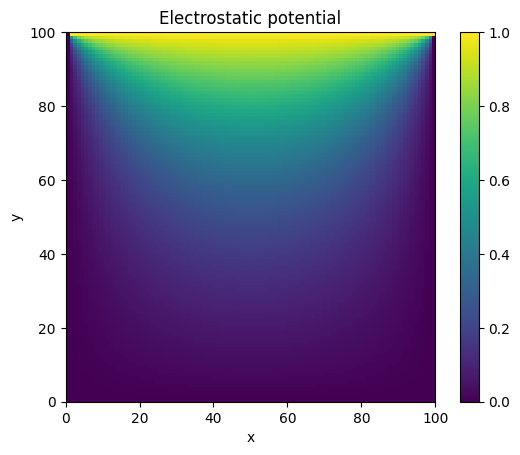

CPU times: user 1.68 s, sys: 12.4 ms, total: 1.69 s
Wall time: 1.69 s


In [36]:
%%time

# Constants
M = 100         # Grid squares on a side
V = 1.0         # Voltage at top wall
target = 1e-4   # Target accuracy

# Initialize with zeros
phi = np.zeros([M+1,M+1],float)
# Boundary condition
phi[0,:] = V
phi[:,0] = 0


omega = 0.93
phi = gaussseidel_solve(phi, omega, target, 1000)

# Plot
plt.title("Electrostatic potential")
plt.xlabel("x")
plt.ylabel("y")
CS = plt.imshow(phi, vmax=1., vmin=0.,origin="upper",extent=[0,M,0,M])
plt.colorbar(CS)
plt.show()

## Initial value problem

In most cases we are studying the time evolution of a certain profile $u(t,\mathbf{x})$.
In this case PDEs desribe the time evolution of the field(s) starting from some initial conditions and obeying boundary conditions.

Let us take the heat equation as an example.
The field $u$ is the temperature $T$.
In one dimension the heat equation reads
$$
\frac{\partial u}{\partial t} = D \, \frac{\partial^2 u}{\partial x^2},
$$
where $D$ is the thermal diffusivity constant.

This equation describes the time evolution of $u(t,x)$ given initial profile
$$
u(t=0,x) = u_0(x),
$$
and boundary conditions
\begin{align*}
u(t,x=0) & = u_{\rm left}(t), \\
u(t,x=L) & = u_{\rm right}(t).
\end{align*}

If $u_{\rm left}(t)$ and $u_{\rm right}(t)$ are time-independent, we know that the solution will approach a stationary profile as $t \to \infty$.

## Finite difference methods

## 1. FTCS scheme

FTCS (Finite Time Centered Space) scheme is the simplest method for solving the heat equation

First we discretize the spatial coordinate into a grid with $N + 1$ points, i.e.
$$
x_k = a k, \qquad k = 0\ldots N, \qquad a = L/N,
$$
and approximate the derivative $\partial^2 u / \partial x^2$ by the lowest order central difference
$$
\frac{\partial^2 u(t,x)}{\partial x^2} \approx \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

To evaluate the time evolution we will work is small time steps of size $h$.
The time derivative is approximated by the forward difference
$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h}.
$$

This gives the following discretized equation
$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$
The method is explicit: to evaluate $u(t+h,x)$ at the next time step we only need to know $u(t,x)$ profile at the present time step.
Denoting the discretized time variable by superscript $n$ (such that $t_n = hn$) and the spatial variable by subscript $k$ (such that $x_k = ak$) we get the following iterative procedure
$$
u^{n+1}_k = u^n_k + r \, (u^n_{k+1} - 2u^n_k + u^n_{k-1}), \qquad k = 1 \ldots N-1.
$$
Here
$$
r \equiv \frac{Dh}{a^2}
$$
is a dimensionless parameter.

In [37]:
import numpy as np

# Single iteration of the FTCS scheme in the time direction
# r = Dh/a^2 is the dimensionless parameter
def heat_FTCS_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    
    # FTCS scheme
    for i in range(1,N):
        unew[i] = u[i] + r * (u[i+1] - 2 * u[i] + u[i-1])
        
    return unew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_FTCS_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    for i in range(nsteps):
        u = heat_FTCS_iteration(u, r)
        
    return u

Let us consider Example 9.3 from M. Newman, *Computational Physics*:

We have a 1 cm long steel container, initially at a temperature 20&deg; C.
It is placed in bath of cold water at 0&deg; C and filled on top with hot water at 50&deg; C.
Our goal is to calculate the temperature profile as function of time.
The thermal diffusivity constant for stainless steel is $D = 4.25 \cdot 10^{-6}$ m$^2$ s$^{-1}$.

We will calculate the profile at times $t = 0.01$ s, $0.1$ s, $0.4$ s, $1$ s, and $10$ s.

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.0425


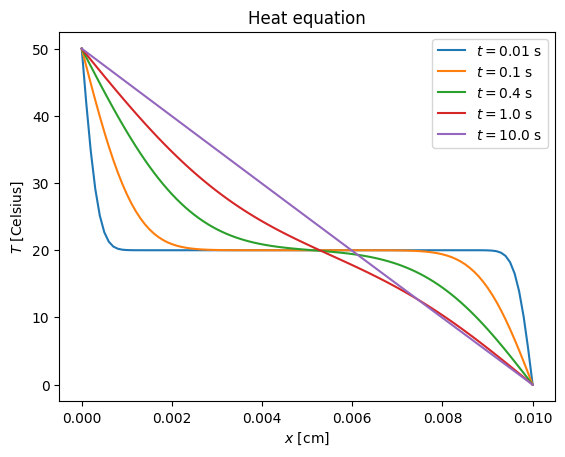

CPU times: user 3.24 s, sys: 43.9 ms, total: 3.29 s
Wall time: 3.29 s


In [38]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-4      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

Try a larger time step such that $r > 1/2$

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.5099999999999999


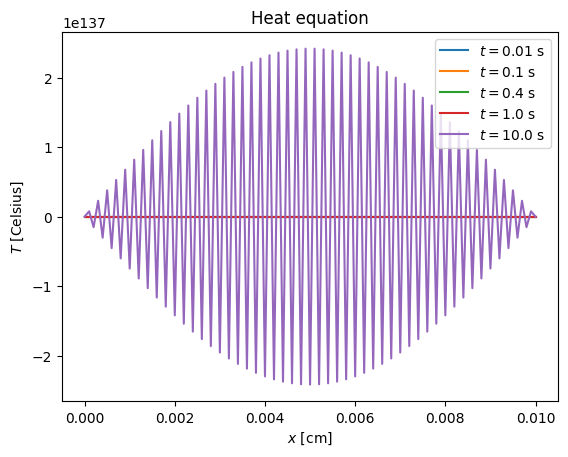

CPU times: user 361 ms, sys: 9.14 ms, total: 371 ms
Wall time: 370 ms


In [39]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1.2e-3      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

What if we increase the spatial size step to bring $r$ back below 1/2?

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.41309999999999986


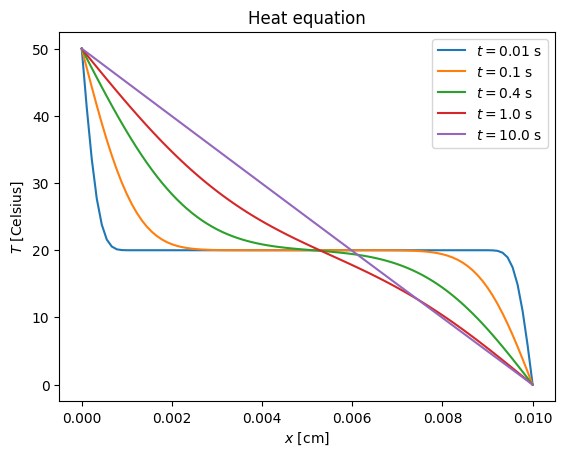

CPU times: user 335 ms, sys: 8.28 ms, total: 344 ms
Wall time: 342 ms


In [9]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 90        # Number of divisions in grid
a = L/N       # Grid spacing
h = 1.2e-3    # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

## 2. Implicit scheme

In the implicit scheme one uses backward difference for the time derivative.
This implies
$$
\frac{\partial u(t+h,x)}{\partial t} \approx \frac{u(t+h,x) - u(t,x)}{h},
$$
thus
$$
\frac{u(t+h,x) - u(t,x)}{h} = D \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2}.
$$
In discretized notation
$$
u^{n+1}_k = u^n_k + r \, (u^{n+1}_{k+1} - 2u^{n+1}_k + u^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
$$
In other words, we have a system of linear equations for $u^{n+1}_i$:
$$
-r u^{n+1}_{k-1} + (1+2r) u^{n+1}_{k} - r u^{n+1}_{k+1} = u^n_k, \qquad k = 1 \ldots N-1.
$$
The system should be solved at each time step. Luckily, the system is tridiagonal, so it is solved in linear time.

In [10]:
import numpy as np

# Solve tridiagonal system of linear equations
#  d: vector of diagonal elements
#  l: vector of elements on the lower subdiagonal
#  u: vector of elements on the upper superdiagonal
# v0: right-hand-side vector
def linsolve_tridiagonal(d, l, u, v0):
    # Initialization
    N = len(v0)
    a = d.copy() # Current diagonal elements
    b = u.copy() # Current upper diagonal elements
    v = v0.copy()
    
    # Gaussian elimination
    for r in range(N):
        if (a[r] == 0.):
            print("Diagonal element is zero! Cannot solve the tridiagonal system with simple Gaussian elimination")
            return None
        b[r] /= a[r]
        v[r] /= a[r]
        a[r] = 1.
        if (r < N - 1):
            a[r + 1] -= l[r+1] * b[r]
            v[r + 1] -= l[r+1] * v[r]
            
    # Backsubstitution
    x = np.empty(N,float)
    
    x[N - 1] = v[N - 1]
    for r in range(N-2,-1,-1):
        x[r] = v[r] - b[r] * x[r + 1]
            
    return x

In [11]:
import numpy as np


# Single iteration of the FTCS scheme in the time direction
# The new field is written into unew
# r = Dh/a^2 is the dimensionless parameter
def heat_implicit_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 1+2.*r)
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    v  = np.array(u[1:N])
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    return unew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_implicit_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    # print("Heat equation with r =", r)
    for i in range(nsteps):
        u = heat_implicit_iteration(u, r)
        
    return u

Solving the heat equation with implicit scheme
r = h*D/a^2 = 4.25


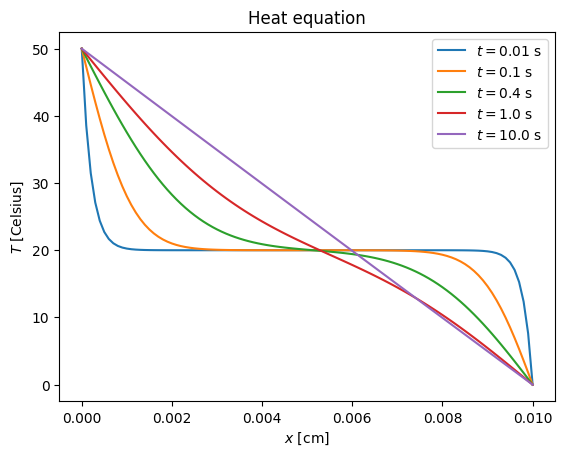

CPU times: user 193 ms, sys: 9.06 ms, total: 202 ms
Wall time: 201 ms


In [12]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step (in s)

print("Solving the heat equation with implicit scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_implicit_solve(u, h, nsteps, a, D)
    # u = heat_FTCS_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

Animate

Solving the heat equation with implicit scheme
r = h*D/a^2 = 0.425
CPU times: user 14.5 s, sys: 319 ms, total: 14.8 s
Wall time: 21.4 s


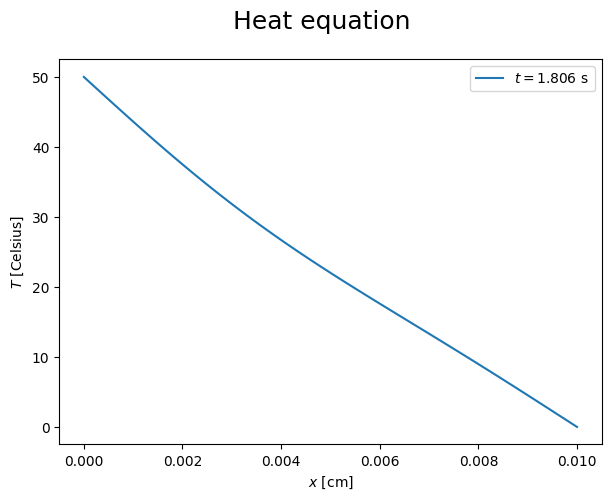

In [13]:
%%time

from matplotlib.animation import FuncAnimation

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-3      # Time-step (in s)

print("Solving the heat equation with implicit scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Heat equation", fontsize = 18)
current_time = 0
def animate_heat_equation_1D(i):
    ax.clear()
    global fps
    niters = round((0.1/fps)/h)
    global u, current_time
    u = heat_implicit_solve(u, h, niters, a, D)
    current_time += h * niters
    # print(current_time)
    
    # plt.title("Heat equation")
    plt.xlabel('${x}$ [cm]')
    plt.ylabel('${T}$ [Celsius]')
    plt.plot(xk,u,label="${t=}$" + "{:.3f}".format(current_time) + " s")
    plt.legend()
    # plt.show()

fps = 30
tend = 2.
ani = FuncAnimation(fig, animate_heat_equation_1D, frames=fps * round(tend) * 10, interval=1000/fps, repeat=False)
#plt.show()

ani.save("heat_equation_1D.gif")

![heat1D](heat_equation_1D.gif)

## 3. Crank-Nicolson scheme

Crank-Nicolson method is a combination of FTCS and implicit schemes.
Essentially it corresponds to approximating the time derivative as average of explicit and implicit methods
$$
\frac{\partial u(t,x)}{\partial t} \approx \frac{1}{2} \left[ D \, \frac{\partial^2 u(t+h,x)}{\partial x^2} + D \, \frac{\partial^2 u(t,x)}{\partial x^2} \right].
$$

Applying central differences to the spatial derivatives we obtain
$$
\frac{u(t+h,x) - u(t,x)}{h} = \frac{D}{2} \frac{u(t+h,x+a) - 2u(t+h,x) + u(t+h,x-a)}{a^2} + \frac{D}{2} \frac{u(t,x+a) - 2u(t,x) + u(t,x-a)}{a^2}.
$$

This corresponds to the following tri-diagonal system of linear equations
$$
-r u^{n+1}_{k-1} + 2(1+r) u^{n+1}_{k} - r u^{n+1}_{k+1} = ru^n_{k-1} + 2(1-r)u^n_k + ru^n_{k+1}, \qquad k = 1 \ldots N-1.
$$

In [14]:
import numpy as np

def heat_crank_nicolson_iteration(u, r):
    N = len(u) - 1
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[0] = u[0]
    unew[N] = u[N]
    
    d  = np.full(N-1, 2*(1+r))
    ud = np.full(N-1, -r)
    ld = np.full(N-1, -r)
    
    # Crank-Nicolson explicit step
    v = u[1:N]*2*(1-r) + u[:-2]*r + u[2:]*r
    v[0]   += r * u[0]
    v[N-2] += r * u[N]
    
    unew[1:N] = linsolve_tridiagonal(d, ld, ud, v)
    
    return unew

def heat_crank_nicolson_solve(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / (a**2)
    for i in range(nsteps):
        u = heat_crank_nicolson_iteration(u, r)
        
    return u


Solving the heat equation with Crank-Nicolson scheme
r = h*D/a^2 = 4.25


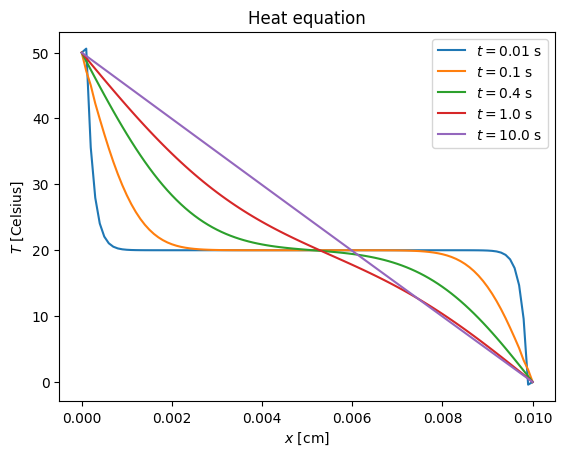

CPU times: user 173 ms, sys: 6.2 ms, total: 179 ms
Wall time: 178 ms


In [15]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step (in s)

print("Solving the heat equation with Crank-Nicolson scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1],float)
# Initial temperature
u[1:N] = Tmid
# Boundary conditions
u[0] = Thi
u[N] = Tlo

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0, 10.0 ]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_crank_nicolson_solve(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
plt.title("Heat equation")
plt.xlabel('${x}$ [cm]')
plt.ylabel('${T}$ [Celsius]')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]) + " s")
plt.legend()
plt.show()

## Heat equation in two dimensions

In two dimensions the heat equation reads
$$
\frac{\partial u}{\partial t} = D \, \left[ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right].
$$

This equation describes the time evolution of $u(t,x,y)$ given initial profile
$$
u(t=0,x,y) = u_0(x,y),
$$
and boundary conditions
\begin{align*}
u(t,x=0,y) & = u_{\rm left}(t;y), \\
u(t,x=L,y) & = u_{\rm right}(t;y), \\
u(t,x=0,y) & = u_{\rm bottom}(t;x), \\
u(t,x=L,y) & = u_{\rm top}(t;x).
\end{align*}

Now we have two perform discretization in both $x$ and $y$ directions.
Taking the same step size $a$ in both directions, we obtain the following discretized FTCS scheme:

$$
u^{n+1}_{i,j} = u^n_{i,j} + r \, (u^n_{i+1,j} - 2u^n_{i,j} + u^n_{i-1,j})
+ r \, (u^n_{i,j+1} - 2u^n_{i,j} + u^n_{i,j-1}), \qquad i = 1 \ldots N-1, \quad j = 1 \ldots M-1.
$$
Here, as before,
$$
r \equiv \frac{Dh}{a^2},
$$
$N = L_x/a$, $M = L_y/a$, and
$$
u^n_{i,j} = u(t + hn, ai, aj).
$$

In [16]:
import numpy as np

# Single iteration of the 2D FTCS scheme in the time direction
# r = Dh/a^2 is the dimensionless parameter
def heat_FTCS_iteration_2D(u, r):
    N, M = u.shape
    
    unew = np.empty_like(u)
    
    # Boundary conditions
    unew[  0, :]   = u[ 0, :]
    unew[N-1, :]   = u[N-1, :]
    unew[ :, 0]    = u[ :, 0]
    unew[ :, M-1]  = u[ :, M-1]
    
    # FTCS scheme
    for i in range(1, M-1):
        for j in range(1, N-1):
            unew[i, j] = u[i, j] + r * (u[i+1, j] - 2 * u[i, j] + u[i-1, j]) + r * (u[i, j+1] - 2 * u[i, j] + u[i, j-1])
            
    return unew

# Perform nsteps 2D FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def heat_FTCS_solve_2D(u0, h, nsteps, a, D = 1.):
    u = u0.copy()
    r = h * D / a**2
    for i in range(nsteps):
        u = heat_FTCS_iteration_2D(u, r)
        
    return u


Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.0425


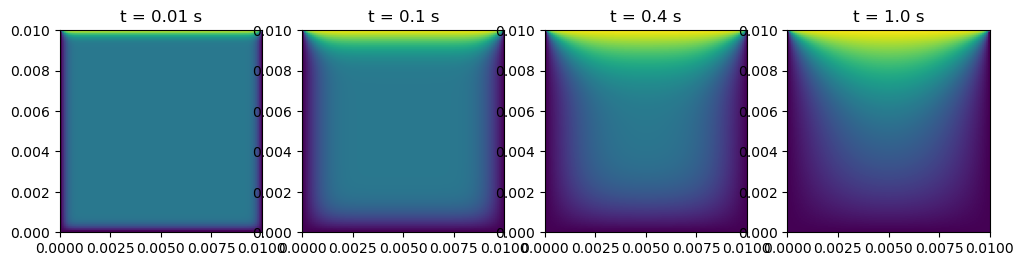

CPU times: user 1min 21s, sys: 1.2 s, total: 1min 22s
Wall time: 1min 22s


In [17]:
%%time

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
M = N
a = L/N       # Grid spacing
h = 1e-4      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1,N+1],float)
# Initial temperature
u[:,:] = Tmid
# Boundary conditions
u[0,:] = Tlo
u[N,:] = Tlo
u[:,0] = Tlo
u[:,M] = Thi

# For the output
times    = [ 0.01, 0.1, 0.4, 1.0]
profiles = []
xk       = [k*a for k in range(0,N+1)]
yk       = [k*a for k in range(0,M+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    u = heat_FTCS_solve_2D(u, h, nsteps, a, D)
    profiles.append(u.copy())
    current_time = time
    
# Plot the initial and final temperature profiles
fig, ax = plt.subplots(1, len(times), figsize=(12, 5))
for i in range(len(ax)):
    ax[i].imshow(profiles[i].T, vmax=Thi, vmin=Tlo, origin="lower", extent=[0,L,0,L])
    ax[i].set_title("t = " + str(times[i]) + " s")
plt.show()

Solving the heat equation with FTCS scheme
r = h*D/a^2 = 0.0425
0.0033
0.0066
0.009899999999999999
0.0132
0.0165
0.0198
0.023100000000000002
0.026400000000000003
0.029700000000000004
0.033
0.0363
0.039599999999999996
0.042899999999999994
0.04619999999999999
0.04949999999999999
0.052799999999999986
0.05609999999999998
0.05939999999999998
0.06269999999999998
0.06599999999999998
0.06929999999999997
0.07259999999999997
0.07589999999999997
0.07919999999999996
0.08249999999999996
0.08579999999999996
0.08909999999999996
0.09239999999999995
0.09569999999999995
0.09899999999999995
0.10229999999999995
0.10559999999999994
0.10889999999999994
0.11219999999999994
0.11549999999999994
0.11879999999999993
0.12209999999999993
0.12539999999999993
0.12869999999999993
0.13199999999999992
0.13529999999999992
0.13859999999999992
0.14189999999999992
0.1451999999999999
0.1484999999999999
0.1517999999999999
0.1550999999999999
0.1583999999999999
0.1616999999999999
0.1649999999999999
0.1682999999999999
0.1715999

1.4388000000000079
1.442100000000008
1.445400000000008
1.448700000000008
1.4520000000000082
1.4553000000000083
1.4586000000000083
1.4619000000000084
1.4652000000000085
1.4685000000000086
1.4718000000000087
1.4751000000000087
1.4784000000000088
1.481700000000009
1.485000000000009
1.488300000000009
1.4916000000000091
1.4949000000000092
1.4982000000000093
1.5015000000000094
1.5048000000000095
1.5081000000000095
1.5114000000000096
1.5147000000000097
1.5180000000000098
1.5213000000000099
1.52460000000001
1.52790000000001
1.53120000000001
1.5345000000000102
1.5378000000000103
1.5411000000000104
1.5444000000000104
1.5477000000000105
1.5510000000000106
1.5543000000000107
1.5576000000000108
1.5609000000000108
1.564200000000011
1.567500000000011
1.570800000000011
1.5741000000000112
1.5774000000000112
1.5807000000000113
1.5840000000000114
1.5873000000000115
1.5906000000000116
1.5939000000000116
1.5972000000000117
1.6005000000000118
1.6038000000000119
1.607100000000012
1.610400000000012
1.61370000

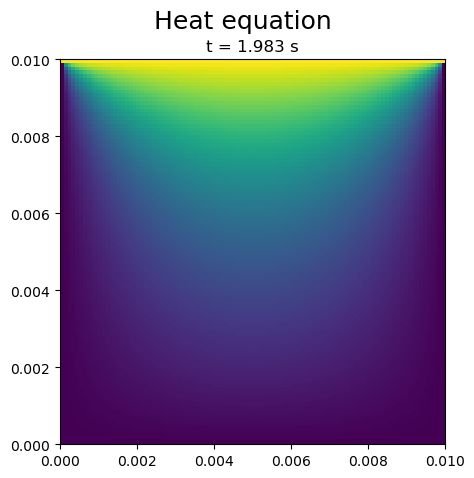

In [18]:
%%time

from matplotlib.animation import FuncAnimation

# Constants
L = 0.01      # Thickness of steel in meters
D = 4.25e-6   # Thermal diffusivity
N = 100       # Number of divisions in grid
M = N
a = L/N       # Grid spacing
h = 1e-4      # Time-step (in s)

print("Solving the heat equation with FTCS scheme")
print("r = h*D/a^2 =",h*D/a**2)

Tlo  = 0.0     # Low temperature in Celsius
Tmid = 20.0    # Intermediate temperature in Celsius
Thi  = 50.0    # High temperature in Celsius

# Initialize
u = np.zeros([N+1,N+1],float)
# Initial temperature
u[:,:] = Tmid
# Boundary conditions
u[0,:] = Tlo
u[N,:] = Tlo
u[:,0] = Tlo
u[:,M] = Thi


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Heat equation", fontsize = 18)
# plt.subplots_adjust(top=1.)
# function that draws each frame of the animation
current_time = 0
def animate_heat_equation(i):
    ax.clear()
    global fps
    niters = round((0.1/fps)/h)
    global u, current_time
    u = heat_FTCS_solve_2D(u, h, niters, a, D)
    current_time += h * niters
    print(current_time)
    
    ax.imshow(u.T, vmax=Thi, vmin=Tlo, origin="lower", extent=[0,L,0,L])
    ax.set_title("t = " + "{:.3f}".format(current_time) + " s")

fps = 30
tend = 2.
ani = FuncAnimation(fig, animate_heat_equation, frames=fps * round(tend * 10), interval=1000/fps, repeat=False)
#plt.show()

ani.save("heat_equation_2D.gif")

![heat2d](heat_equation_2D.gif)

## Wave equation

Wave equation is an example of a second-order linear PDE describing the waves and standing wave fields. In one dimensions it reads
$$
\frac{\partial^2 \phi}{\partial t^2} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
$$

Since it is a 2nd order PDE, it is supplemented by initial conditions for both $\phi(t=0,x)$ and $\phi_t'(t=0,x)$:
\begin{align*}
\phi(t=0,x) & = \phi_0(x) ,\\
\phi_t'(t=0,x) & = \phi'_0(x).
\end{align*}

The boundary conditions can be of either Dirichlet
\begin{align*}
\phi(t,x=0) & = \phi_{\rm left}(t) ,\\
\phi(t,x=L) & = \phi_{\rm right}(t),
\end{align*}
or Neumann 
\begin{align*}
\phi'_x(t,x=0) & = \phi'_{\rm left}(t) ,\\
\phi'_x(t,x=L) & = \phi'_{\rm right}(t),
\end{align*}
forms.

We shall focus on the Dirichlet form.

## Finite difference approach


To deal with the second-order time derivative we denote
$$
\psi(t,x) \equiv \frac{\partial \phi}{\partial t}.
$$
This way we are dealing with a system of first-order (in $t$) PDEs
\begin{align*}
\frac{\partial \phi}{\partial t} = \psi(t,x), \\
\frac{\partial \psi}{\partial t} = v^2 \frac{\partial^2 \phi}{\partial x^2}.
\end{align*}

To apply the finite difference method we first approximate the derivative $\partial^2 \phi / \partial x^2$ by the lowest order central difference, just like for the heat equation,
$$
\frac{\partial^2 \phi(t,x)}{\partial x^2} \approx \frac{\phi(t,x+a) - 2\phi(t,x) + \phi(t,x-a)}{a^2}.
$$

To solve the PDEs numerically we apply the same procedure as for the heat equation, but for $\phi(t,x)$ and $\psi(t,x)$ simultaneously.
Denoting $\phi(t = nh,x = ka) = \phi^n_k$ and $\psi(t = nh,x = ka) = \psi^n_k$ we get

### FTCS scheme
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^n_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^n_{k+1} - 2\phi^n_k + \phi^n_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}

### Implicit scheme
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^{n+1}_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}

### Crank-Nicolson scheme
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + \frac{h}{2} \left[ \psi^{n+1}_k + \psi^{n}_k\right], \\
\psi^{n+1}_k & = \psi^n_k + \frac{r}{2} \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}) + \frac{r}{2} \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}

In [19]:
import numpy as np

# Single iteration of the FTCS scheme in the time direction
# h is the time step
# r = Dh/a^2 is the dimensionless parameter
def wave_FTCS_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    # Boundary conditions (here static Dirichlet)
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    
    # FTCS scheme
    for i in range(1,N):
        phinew[i] = phi[i] + h * psi[i]
        psinew[i] = psi[i] + r * (phi[i+1] - 2 * phi[i] + phi[i-1])
        
    return phinew, psinew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def wave_FTCS_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_FTCS_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with FTCS scheme
r = h*v^2/a^2 = 1.0000000000000002


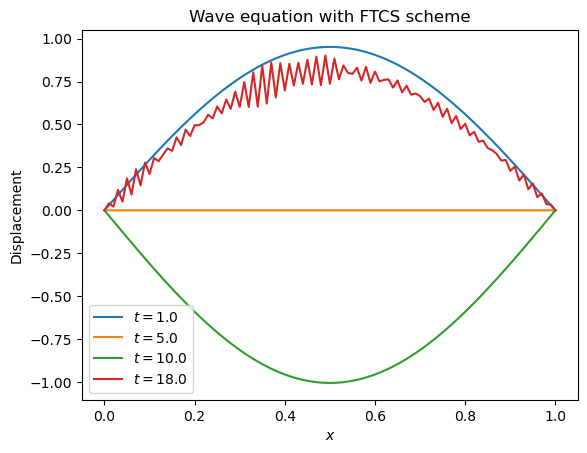

CPU times: user 325 ms, sys: 11.1 ms, total: 336 ms
Wall time: 204 ms


In [20]:
%%time

# Constants
L = 1         # Length
v = 0.1       # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step

print("Solving the wave equation with FTCS scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)



# Initialize
phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

# For the output
times    = [ 1., 5., 10., 18.]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    phi, psi = wave_FTCS_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with FTCS scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

CPU times: user 8.24 s, sys: 2.64 s, total: 10.9 s
Wall time: 9.82 s


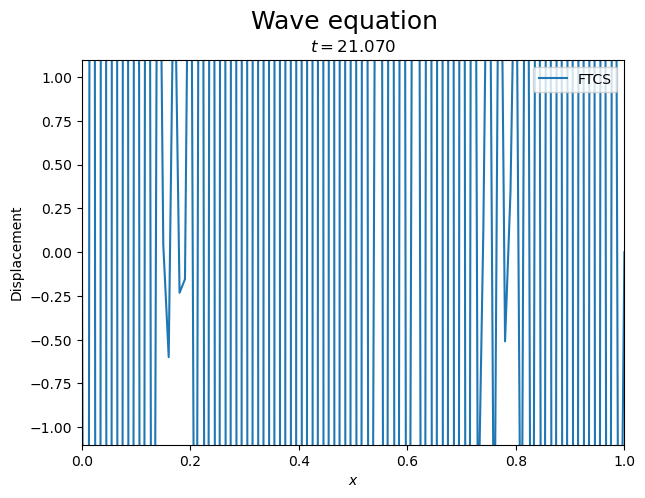

In [21]:
%%time

from matplotlib.animation import FuncAnimation

# Constants
L = 1         # Length
v = 0.1       # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step

# For plotting
xk       = [k*a for k in range(0,N+1)]

# Initialize for the three schemes
phi1 = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi1 = np.zeros([N+1],float)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Wave equation", fontsize = 18)
current_time = 0
def animate_wave_equation_1D_FTCS(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi1, psi1, phi2, psi2, phi3, psi3, current_time
    phi1, psi1 = wave_FTCS_solve(phi1, psi1, h, nsteps, a, v)
    current_time += h * nsteps
    # print(current_time)
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-1.1,1.1)
    plt.plot(xk,phi1,label="FTCS")
    plt.legend()
    # plt.show()

fps = 30
tend = 20.
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D_FTCS, frames=round(fps * tottime), interval=1000/fps, repeat=False)
#plt.show()

ani.save("wave_equation_1D_FTCS.gif")

![1dwaveFTCS](wave_equation_1D_FTCS.gif)

### Implicit scheme
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + h \psi^{n+1}_k, \\
\psi^{n+1}_k & = \psi^n_k + r \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}

Substituting the first equation into the second one gets the tridiagonal system of linear equations for $\psi^{n+1}_k$:
$$
-rh \psi^{n+1}_{k+1} + (1+2rh) \psi^{n+1}_k - rh \psi^{n+1}_{k-1} = \psi^n_k + r \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \quad k = 1\ldots N-1
$$

In [22]:
import numpy as np

# Single iteration of the FTCS scheme in the time direction
# h is the time step
# r = Dh/a^2 is the dimensionless parameter
def wave_implicit_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    # Boundary conditions (here static Dirichlet)
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    # Tridiagonal system for psi
    d  = np.full(N-1, 1+2.*r*h)
    ud = np.full(N-1, -r*h)
    ld = np.full(N-1, -r*h)
    v  = np.array(psi[1:N] + r*phi[2:] - 2*r*phi[1:N] + r*phi[:-2])
    v[0]   += r * h * psi[0]
    v[N-2] += r * h * psi[N]
    
    psinew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    # Final step for phi
    for i in range(1,N):
        phinew[i] = phi[i] + h * psinew[i]
        
    return phinew, psinew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def wave_implicit_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_implicit_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with FTCS scheme
r = h*v^2/a^2 = 1.0000000000000002


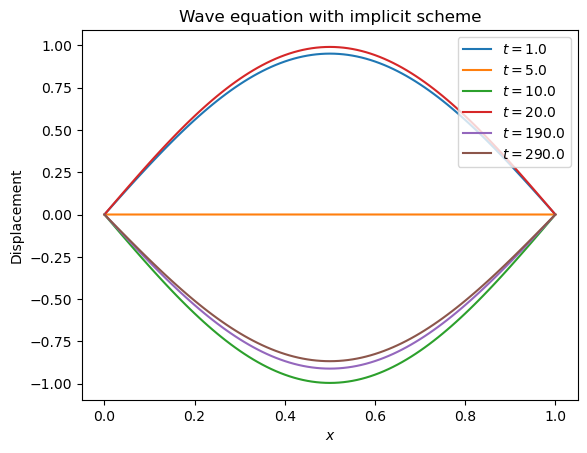

CPU times: user 4.3 s, sys: 233 ms, total: 4.53 s
Wall time: 4.22 s


In [23]:
%%time

# Constants
L = 1         # Length
v = 0.1       # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step

print("Solving the wave equation with FTCS scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)



# Initialize
phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

# For the output
times    = [ 1., 5., 10., 20., 190., 290.]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    phi, psi = wave_implicit_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with implicit scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

### Crank-Nicolson scheme
\begin{align*}
\phi^{n+1}_k & = \phi^{n}_k + \frac{h}{2} \left[ \psi^{n+1}_k + \psi^{n}_k\right], \\
\psi^{n+1}_k & = \psi^n_k + \frac{r}{2} \, (\phi^{n+1}_{k+1} - 2\phi^{n+1}_k + \phi^{n+1}_{k-1}) + \frac{r}{2} \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}), \qquad k = 1 \ldots N-1.
\end{align*}

Substituting the first equation into the second one gets the tridiagonal system of linear equations for $\psi^{n+1}_k$:
$$
-rh \psi^{n+1}_{k+1} + 2(1+rh) \psi^{n+1}_k - rh \psi^{n+1}_{k-1} = 2 \psi^n_k + 2r \, (\phi^{n}_{k+1} - 2\phi^{n}_k + \phi^{n}_{k-1}) + rh \, (\psi^{n}_{k+1} - 2\psi^{n}_k + \psi^{n}_{k-1}), \quad k = 1\ldots N-1.
$$

In [24]:
import numpy as np

# Single iteration of the FTCS scheme in the time direction
# h is the time step
# r = Dh/a^2 is the dimensionless parameter
def wave_crank_nicolson_iteration(phi, psi, h, r):
    N = len(phi) - 1
    
    phinew = np.empty_like(phi)
    psinew = np.empty_like(psi)
    
    # Boundary conditions (here static Dirichlet)
    phinew[0] = phi[0]
    phinew[N] = phi[N]
    psinew[0] = 0.
    psinew[N] = 0.
    
    # Tridiagonal system for psi
    d  = np.full(N-1, 2*(1+r*h))
    ud = np.full(N-1, -r*h)
    ld = np.full(N-1, -r*h)
    v  = np.array(2*psi[1:N] + 2*r*phi[2:] - 4*r*phi[1:N] + 2*r*phi[:-2] \
                  + r*h*psi[2:] - 2*r*h*psi[1:N] + r*h*psi[:-2])
    v[0]   += r * h * psi[0]
    v[N-2] += r * h * psi[N]
    
    psinew[1:N] = linsolve_tridiagonal(d,ld,ud,v)
    
    # Final step for phi
    for i in range(1,N):
        phinew[i] = phi[i] + h * (psinew[i] + psi[i]) / 2
        
    return phinew, psinew


# Perform nsteps FTCS time iterations for the heat equation
# u0: the initial profile
# h: the size of the time step
# nsteps: number of time steps
# a: the spatial cell size
# D: the diffusion constant
def wave_crank_nicolson_solve(phi0, psi0, h, nsteps, a, v = 1.):
    phi = phi0.copy()
    psi = psi0.copy()
    r = h * v**2 / a**2
    for i in range(nsteps):
        phi, psi = wave_crank_nicolson_iteration(phi, psi, h, r)
        
    return phi, psi

Solving the wave equation with FTCS scheme
r = h*v^2/a^2 = 1.0000000000000002
100
400
500
1000
17000
10000


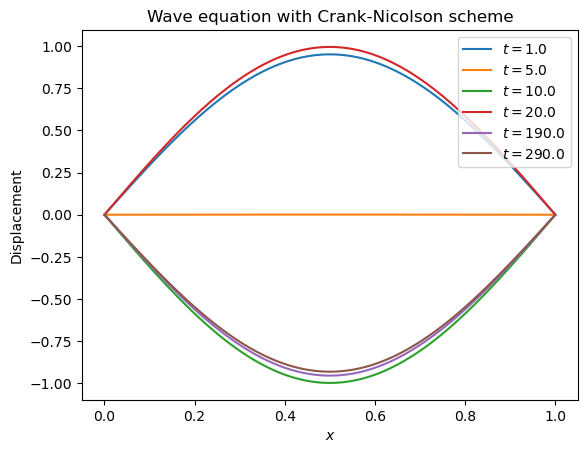

CPU times: user 4.79 s, sys: 242 ms, total: 5.04 s
Wall time: 4.7 s


In [25]:
%%time

# Constants
L = 1         # Length
v = 0.1       # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step

print("Solving the wave equation with FTCS scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)



# Initialize
phi = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi = np.zeros([N+1],float)

# For the output
times    = [ 1., 5., 10., 20., 190., 290.]
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    print(nsteps)
    phi, psi = wave_crank_nicolson_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with Crank-Nicolson scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

Compare the three

CPU times: user 16.2 s, sys: 2.82 s, total: 19.1 s
Wall time: 18.1 s


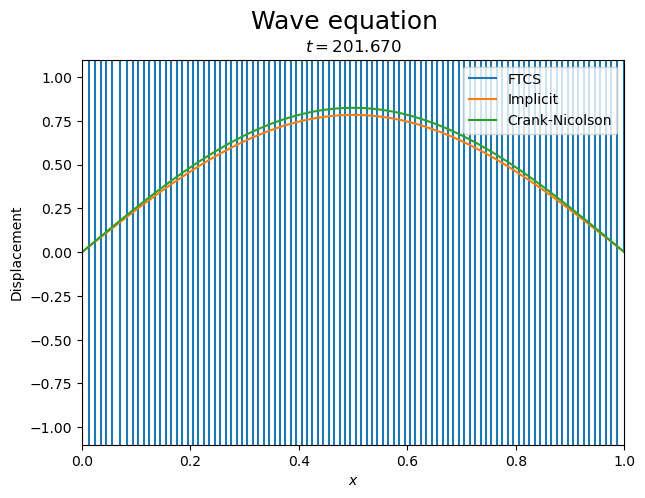

In [26]:
%%time

from matplotlib.animation import FuncAnimation

# Constants
L = 1         # Length
v = 0.1       # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-2      # Time-step

# For plotting
xk       = [k*a for k in range(0,N+1)]

# Initialize for the three schemes
phi1 = np.array([np.sin(k*np.pi/N) for k in range(N+1)])
psi1 = np.zeros([N+1],float)
phi2 = phi1.copy()
psi2 = psi1.copy()
phi3 = phi1.copy()
psi3 = psi1.copy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Wave equation", fontsize = 18)
current_time = 0
def animate_wave_equation_1D(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi1, psi1, phi2, psi2, phi3, psi3, current_time
    phi1, psi1 = wave_FTCS_solve(phi1, psi1, h, nsteps, a, v)
    phi2, psi2 = wave_implicit_solve(phi2, psi2, h, nsteps, a, v)
    phi3, psi3 = wave_crank_nicolson_solve(phi3, psi3, h, nsteps, a, v)
    current_time += h * nsteps
    # print(current_time)
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-1.1,1.1)
    plt.plot(xk,phi1,label="FTCS")
    plt.plot(xk,phi2,label="Implicit")
    plt.plot(xk,phi3,label="Crank-Nicolson")
    plt.legend()
    # plt.show()

fps = 30
tend = 200.
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D, frames=round(fps * tottime), interval=1000/fps, repeat=False)
#plt.show()

ani.save("wave_equation_1D.gif")

Exercise 9.5:

Solving the wave equation with FTCS scheme
r = h*v^2/a^2 = 100.0


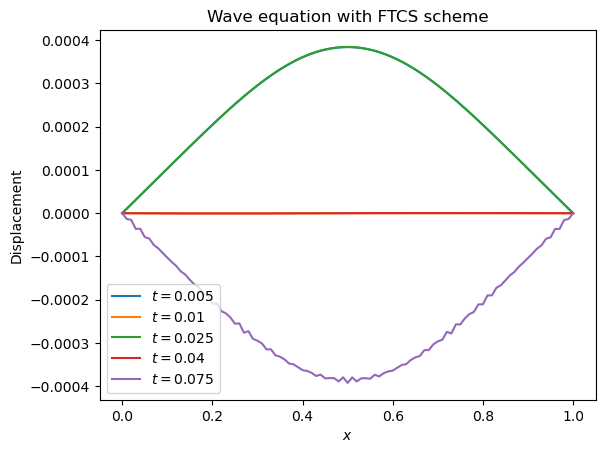

CPU times: user 4.19 s, sys: 77.8 ms, total: 4.27 s
Wall time: 4.13 s


In [27]:
%%time

# Constants
L = 1         # Length
d = 0.1       # Initial profile
sig = 0.3     # Initial profile
v = 100.      # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-6      # Time-step

print("Solving the wave equation with FTCS scheme")
print("r = h*v^2/a^2 =",h*v**2/a**2)


# Initialize
phi = np.zeros([N+1],float)
psi = np.array([a*k * (L - a*k) / L**2 * np.exp(-(k*a-d)**2/2/sig**2) for k in range(N+1)])

# For the output
times    = [ 1.e-4, 2.e-4, 5.e-4, 8.e-4, 1.5e-3]
for i in range(len(times)):
    times[i] *= 50.
profiles = []
xk       = [k*a for k in range(0,N+1)]

current_time = 0.
for time in times:
    nsteps = round((time - current_time)/h)
    phi, psi = wave_FTCS_solve(phi, psi, h, nsteps, a, v)
    profiles.append(phi.copy())
    current_time = time
    
plt.title("Wave equation with FTCS scheme")
plt.xlabel('${x}$')
plt.ylabel('Displacement')
for i in range(len(times)):
    plt.plot(xk,profiles[i],label="${t=}$" + str(times[i]))
plt.legend()
plt.show()

CPU times: user 12.5 s, sys: 2.66 s, total: 15.2 s
Wall time: 13.8 s


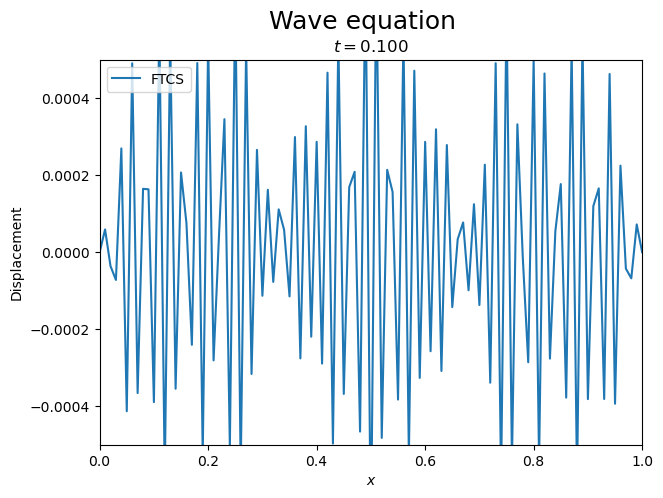

In [28]:
%%time

# Constants
L = 1         # Length
d = 0.1       # Initial profile
sig = 0.3     # Initial profile
v = 100.      # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-6      # Time-step


# Initialize
phi1 = np.zeros([N+1],float)
psi1 = np.array([a*k * (L - a*k) / L**2 * np.exp(-(k*a-d)**2/2/sig**2) for k in range(N+1)])
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Wave equation", fontsize = 18)
current_time = 0
def animate_wave_equation_1D_pulse_FTCS(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi1, psi1, current_time
    phi1, psi1 = wave_FTCS_solve(phi1, psi1, h, nsteps, a, v)
    current_time += h * nsteps
    # print(current_time)
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-0.0005,0.0005)
    plt.plot(xk,phi1,label="FTCS")
    plt.legend()
    # plt.show()

fps = 30
tend = 0.1
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D_pulse_FTCS, frames=round(fps * tottime), interval=1000/fps, repeat=False)
#plt.show()

ani.save("wave_equation_1D_pulse_FTCS.gif")

![1dwavepulse](wave_equation_1D_pulse_FTCS.gif)

Compare with implicit and Crank-Nicolson

CPU times: user 1min 14s, sys: 4.41 s, total: 1min 18s
Wall time: 1min 17s


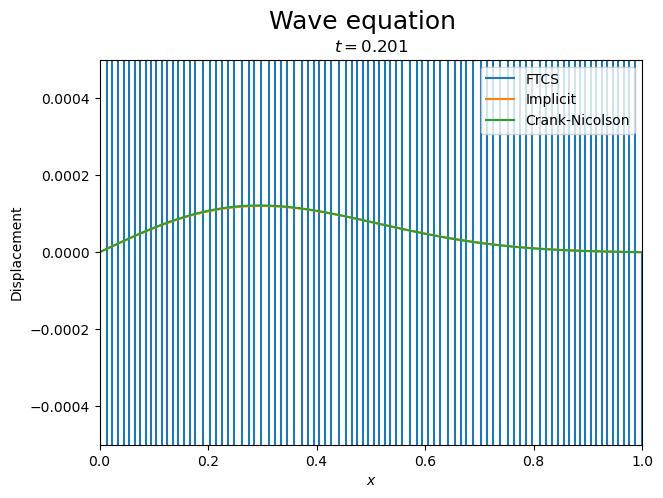

In [29]:
%%time

# Constants
L = 1         # Length
d = 0.1       # Initial profile
sig = 0.3     # Initial profile
v = 100.      # Wave propagation speed
N = 100       # Number of divisions in grid
a = L/N       # Grid spacing
h = 1e-6      # Time-step


# Initialize
phi1 = np.zeros([N+1],float)
psi1 = np.array([a*k * (L - a*k) / L**2 * np.exp(-(k*a-d)**2/2/sig**2) for k in range(N+1)])
phi2 = phi1.copy()
psi2 = psi1.copy()
phi3 = phi1.copy()
psi3 = psi1.copy()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5, forward=True)
fig.suptitle("Wave equation", fontsize = 18)
current_time = 0
def animate_wave_equation_1D_pulse(i):
    ax.clear()
    global fps, tottime, tend
    nsteps = round((tend/tottime/fps)/h)
    global phi1, psi1, phi2, psi2, phi3, psi3, current_time
    phi1, psi1 = wave_FTCS_solve(phi1, psi1, h, nsteps, a, v)
    phi2, psi2 = wave_implicit_solve(phi2, psi2, h, nsteps, a, v)
    phi3, psi3 = wave_crank_nicolson_solve(phi3, psi3, h, nsteps, a, v)
    current_time += h * nsteps
    # print(current_time)
    
    plt.title("${t=}$" + "{:.3f}".format(current_time))
    plt.xlabel('${x}$')
    plt.ylabel('Displacement')
    plt.xlim(0,L)
    plt.ylim(-0.0005,0.0005)
    plt.plot(xk,phi1,label="FTCS")
    plt.plot(xk,phi2,label="Implicit")
    plt.plot(xk,phi3,label="Crank-Nicolson")
    plt.legend()
    # plt.show()

fps = 30
tend = 0.2
tottime = 10.
ani = FuncAnimation(fig, animate_wave_equation_1D_pulse, frames=round(fps * tottime), interval=1000/fps, repeat=False)
#plt.show()

ani.save("wave_equation_1D_pulse.gif")

![1dwavepulse](wave_equation_1D_pulse.gif)